# Budget Bus Numbers

Hello, this is a script which has a "burner" API key for OCR Space OCR API which works alright

### Steps
1. Find bounding box of bus numbers
2. Crop image to bounding box location
3. OCR on cropped image

bus_ext_1.jpeg	bus_ext_4.jpg  bus_ext_7.jpg	   bus_int_1.jpg
bus_ext_2.jpg	bus_ext_5.jpg  bus_ext_8.jpeg	   non_bus_1.jpg
bus_ext_3.jpg	bus_ext_6.jpg  bus_high_res_1.jpg  readme.txt


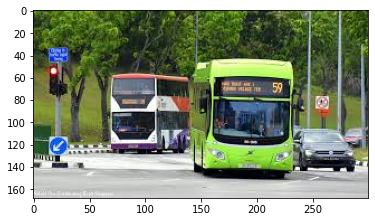

In [1]:
# Libaries
import requests, json, numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from os import getenv, stat
from pprint import pprint

# Global Variables
test_image = "test_img/bus_ext_1.jpeg"
!ls test_img


image = Image.open(test_image)
imshow(image)

## Use Azure Custom Vision to Find Bounding Box of Image

In [2]:
## Ensure that the Image is of the Acceptable Size
while stat(test_image).st_size > 4100000:
    image = Image.open(test_image)
    x = int(image.size[0]*0.9)
    y = int(image.size[1]*0.9)
    image = image.resize((x,y), Image.ANTIALIAS)
    test_image = "/tmp/resized.jpg"
    image.save(test_image)
    print("Lowered Size of Image by 19%")

In [3]:
# Use the Custom Vision Docker File (Superior Speed and Cost)
# NOTE: Change the following docker folder if you are using a different docker folder name
! ./custom_vision_docker/run_docker.sh
with open(test_image, 'rb') as image_file:
    custom_vision_response = requests.post("http://127.0.0.1/image", data=image_file, headers={"Content-Type": "application/octet-stream"} )
! docker container kill $(docker ps -q)

Sending build context to Docker daemon  44.15MB
Step 1/7 : FROM python:3.7-slim
 ---> 69afd9568c9d
Step 2/7 : RUN pip install -U pip
 ---> Using cache
 ---> bf22b1be08be
Step 3/7 : RUN pip install numpy==1.17.3 tensorflow==2.0.0 flask pillow
 ---> Using cache
 ---> 059c30d4c2f6
Step 4/7 : COPY app /app
 ---> Using cache
 ---> 84e8634eac15
Step 5/7 : EXPOSE 80
 ---> Using cache
 ---> 5bbb83d53e97
Step 6/7 : WORKDIR /app
 ---> Using cache
 ---> 799abefd05b1
Step 7/7 : CMD python -u app.py
 ---> Using cache
 ---> 822865e9ae9e
Successfully built 822865e9ae9e
Successfully tagged custom_vision:latest
9846de0709f5b173c9ff8349394278ed3642a120fc5f428074ac3036d2d302ab
9846de0709f5


In [4]:
json_response= json.loads(custom_vision_response.text)
bounding_boxes = json_response['predictions']
threshold = 0.2 #Threshold on what probability corresponds to a valid bounding box

# Extract Best Bounding Box with Probability > threshold
max_probability = -1 
for bounding_box in bounding_boxes:
    #print("Box:", bounding_box['probability'])
    max_probability = max(max_probability, bounding_box['probability'])

if max_probability < threshold:
    print("No Valid Bounding Boxes Found")
    raise Exception("No Bounding Boxes")
for i in bounding_boxes:
    if i['probability'] == max_probability:
        bounding_box = i 
        print(bounding_box)

{'boundingBox': {'height': 0.14775178, 'left': 0.55499665, 'top': 0.31878927, 'width': 0.2014844}, 'probability': 0.50747418, 'tagId': 0, 'tagName': 'bus_number'}


In [5]:
bounding_box = bounding_box['boundingBox']
print("Bounding Box:", bounding_box)

Bounding Box: {'height': 0.14775178, 'left': 0.55499665, 'top': 0.31878927, 'width': 0.2014844}


## Use Python Image Libary to Crop Image at Bounding Box

Image of Bus Number


[]

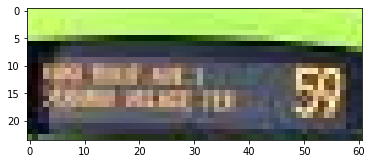

In [6]:
# Import Test Image into Python
raw_image = Image.open(test_image)
width, height = raw_image.size

# Set Points for Cropped Image to Bounding Box
left = width*bounding_box['left']
right = left + width*bounding_box['width']
top = height*bounding_box['top']
bottom = top + height*bounding_box['height']

# Crop Image
bus_num_image = raw_image.crop((left, top, right, bottom))
print("Image of Bus Number")
imshow(np.asarray(bus_num_image)) #Display the Image
plt.plot()

Cropped Image


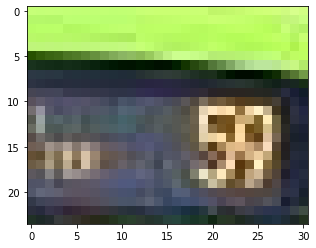

In [7]:
ocr_crop_percentage = 0.5
# Crop Away ocr_crop_percentage of Left Side for OCR Reasons
width, height = bus_num_image.size
left = width * ocr_crop_percentage
right = width
top = 0
bottom = height

ocr_image = bus_num_image.crop((left, top, right, bottom))

# Resize Image with Interpolation if height too big (somehow OCR on Azure doesn't work too well with too sharp of bus numbers)
width, height = ocr_image.size
if height > 50:
    ocr_image = ocr_image.resize((int(width*50/height),50),Image.ANTIALIAS) # Ensure the aspect ratio doesn't change
print("Cropped Image")
imshow(np.asarray(ocr_image)) #Display the Image

# Save OCR Ready Image
ocr_image_file = "ocr.png"
ocr_image.save(ocr_image_file)

## Improve Image Quality with Image Magick

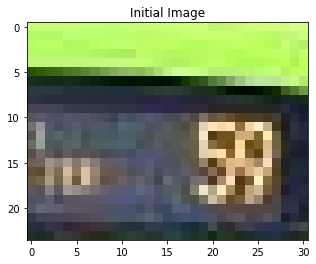

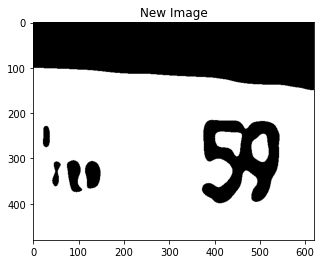

In [8]:
test_image = Image.open("ocr.png")
plt.title("Initial Image")
plt.imshow(test_image)
plt.show()

! convert ocr.png -resize 2000% -colorspace gray +dither -type bilevel -negate resized.png

test_image = Image.open("resized.png")
plt.title("New Image")
plt.imshow(test_image)
plt.show()

## Send Image to OCR API

In [9]:
def ocr_space_file(filename, overlay=False, api_key='5fbfe9786f88957', language='eng'):
    """ OCR.space API request with local file.
        Python3.5 - not tested on 2.7
    :param filename: Your file path & name.
    :param overlay: Is OCR.space overlay required in your response.
                    Defaults to False.
    :param api_key: OCR.space API key.
                    Defaults to 'helloworld'.
    :param language: Language code to be used in OCR.
                    List of available language codes can be found on https://ocr.space/OCRAPI
                    Defaults to 'en'.
    :return: Result in JSON format.
    """

    payload = {'isOverlayRequired': overlay,
               'apikey': api_key,
               'language': language,
               'OCREngine': 2
               }
    with open(filename, 'rb') as f:
        r = requests.post('https://api.ocr.space/parse/image',
                          files={filename: f},
                          data=payload,
                          )
    return r.content.decode()


def parse_image(img_name):
    response = ocr_space_file(img_name)
    result = json.loads(response)
    pprint(result)
    text = result["ParsedResults"][0]["ParsedText"]
    text = text.split("\n")[0]
    return text


In [10]:
try:
    out = parse_image("resized.png")
except Exception as e:
    print(e)
    out = ""
    
done = False
if out != "":
    print("Number Detected:", out)
    done = True
else:
    out = parse_image("ocr.png")

if out != "" and not done:
    print("Number Detected 2:", out)
elif not done:
    print("Cant Read Number on Bus")

{'IsErroredOnProcessing': False,
 'OCRExitCode': 1,
 'ParsedResults': [{'ErrorDetails': '',
                    'ErrorMessage': '',
                    'FileParseExitCode': 1,
                    'ParsedText': '59',
                    'TextOrientation': '0',
                    'TextOverlay': {'HasOverlay': True,
                                    'Lines': [],
                                    'Message': 'Total lines: 0'}}],
 'ProcessingTimeInMilliseconds': '703',
 'SearchablePDFURL': ''}
Number Detected: 59
